In [29]:
import matplotlib
import matplotlib.pyplot as plt
import torch
import numpy as np
import scipy.io as sio

from dataset import Darcys_Dataset
from unet2d_spatial import Unet2D_Spatial
from diffuser import GaussianDiffusion
from physics_loss import Darcy_loss

In [2]:
ds = Darcys_Dataset('../data/darcy_data_r64_N200.mat')

Loaded 200 samples from ../data/darcy_data_r64_N200.mat
Shape of x: torch.Size([200, 1, 64, 64])


### Visualization of Data

In [3]:
x_range = torch.linspace(0, 1, 64+1)[:-1]
y_range = torch.linspace(0, 1, 64+1)[:-1]
X, Y = torch.meshgrid(x_range, y_range, indexing='ij')

In [5]:
a = ds[4:9]['x'].squeeze()
u = ds[4:9]['y'].squeeze()

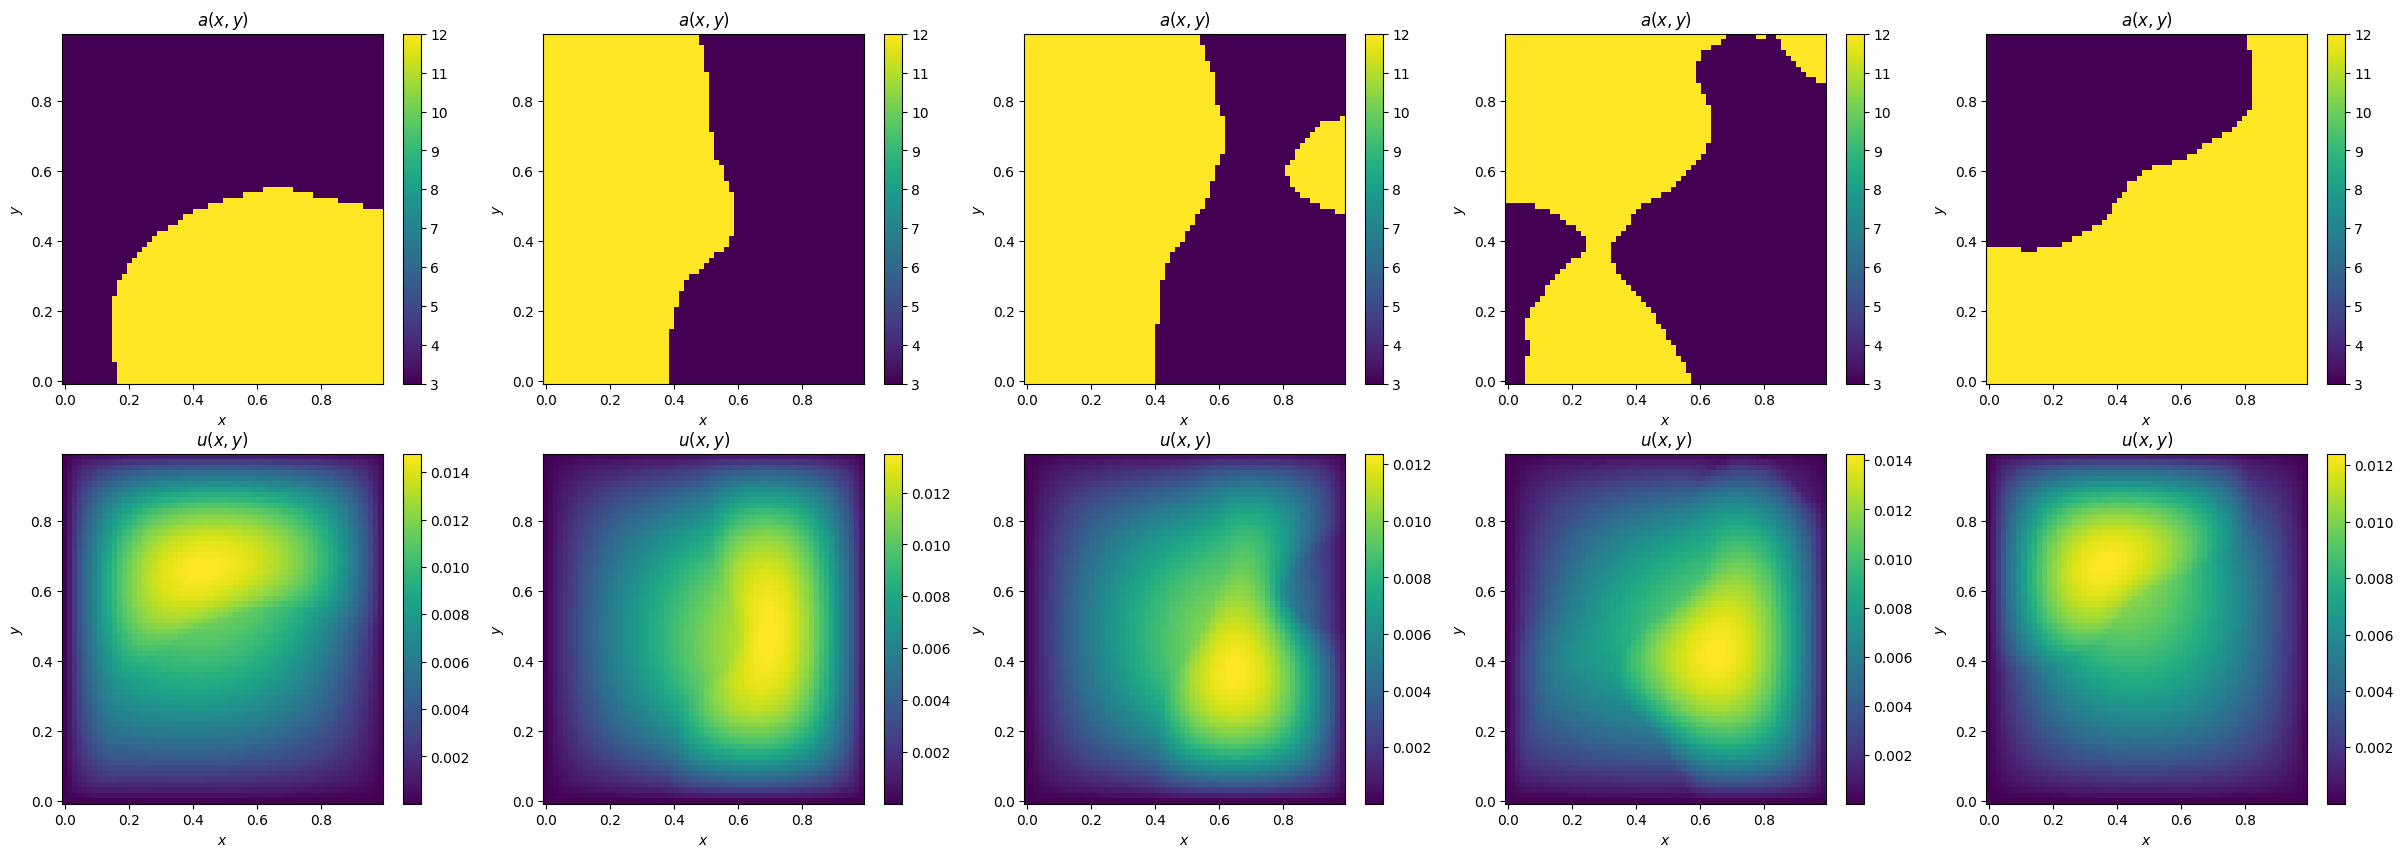

In [6]:
fig, ax = plt.subplots(2, 5, figsize=(30, 10))
for i in range(5):
    im1 = ax[0, i].pcolormesh(X, Y, a[i])
    ax[0, i].set_xlabel('$x$')
    ax[0, i].set_ylabel('$y$')
    ax[0, i].set_title('$a(x, y)$')
    fig.colorbar(im1, ax=ax[0, i])

    im2 = ax[1, i].pcolormesh(X, Y, u[i])
    ax[1, i].set_xlabel('$x$')
    ax[1, i].set_ylabel('$y$')
    ax[1, i].set_title('$u(x, y)$')
    fig.colorbar(im2, ax=ax[1, i])

In [7]:
fig.savefig('../assets/darcy/darcy_visualization.png', dpi=300, bbox_inches='tight')

### Model Test

In [8]:
darcy_mask = lambda x: 1 / (1 + torch.exp(-x)) * 9 + 3

In [9]:
model = Unet2D_Spatial(
    channels=1,
    cond_channels=1,
    channel_mults=(1, 2, 4, 8),
    init_conv_channels=32,
    init_conv_kernel_size=5
)
diffusion_model = GaussianDiffusion(
    model=model,
    sample_size=(1, 64, 64),
    timesteps=600,
    objective='pred_x0',
    output_mask=darcy_mask
).to("cuda:0")

In [10]:
x = ds[40:72]['x']
y = ds[40:72]['y']

In [11]:
def make_prediction(diffusion_model, cond, physics_loss_weight, error_calibration=False):
    if error_calibration and physics_loss_weight > 0.0:
        weights = torch.load(f"../ckpts/ddpm/darcy_{physics_loss_weight:.2f}phyloss(ec)/ckpt.pt")
    else:
        weights = torch.load(f"../ckpts/ddpm/darcy_{physics_loss_weight:.2f}phyloss/ckpt.pt")
    diffusion_model.model.load_state_dict(weights)
    x_pred = diffusion_model.sample(cond=cond)

    return x_pred.detach().cpu()

In [14]:
x_pred000 = make_prediction(diffusion_model, y, 0.00)
x_pred001 = make_prediction(diffusion_model, y, 0.01)
x_pred005 = make_prediction(diffusion_model, y, 0.05)
x_pred010 = make_prediction(diffusion_model, y, 0.10)
x_pred001_ec = make_prediction(diffusion_model, y, 0.01, error_calibration=True)
x_pred005_ec = make_prediction(diffusion_model, y, 0.05, error_calibration=True)
x_pred010_ec = make_prediction(diffusion_model, y, 0.10, error_calibration=True)

DDPM sampling: 100%|██████████| 600/600 [00:31<00:00, 19.18it/s]


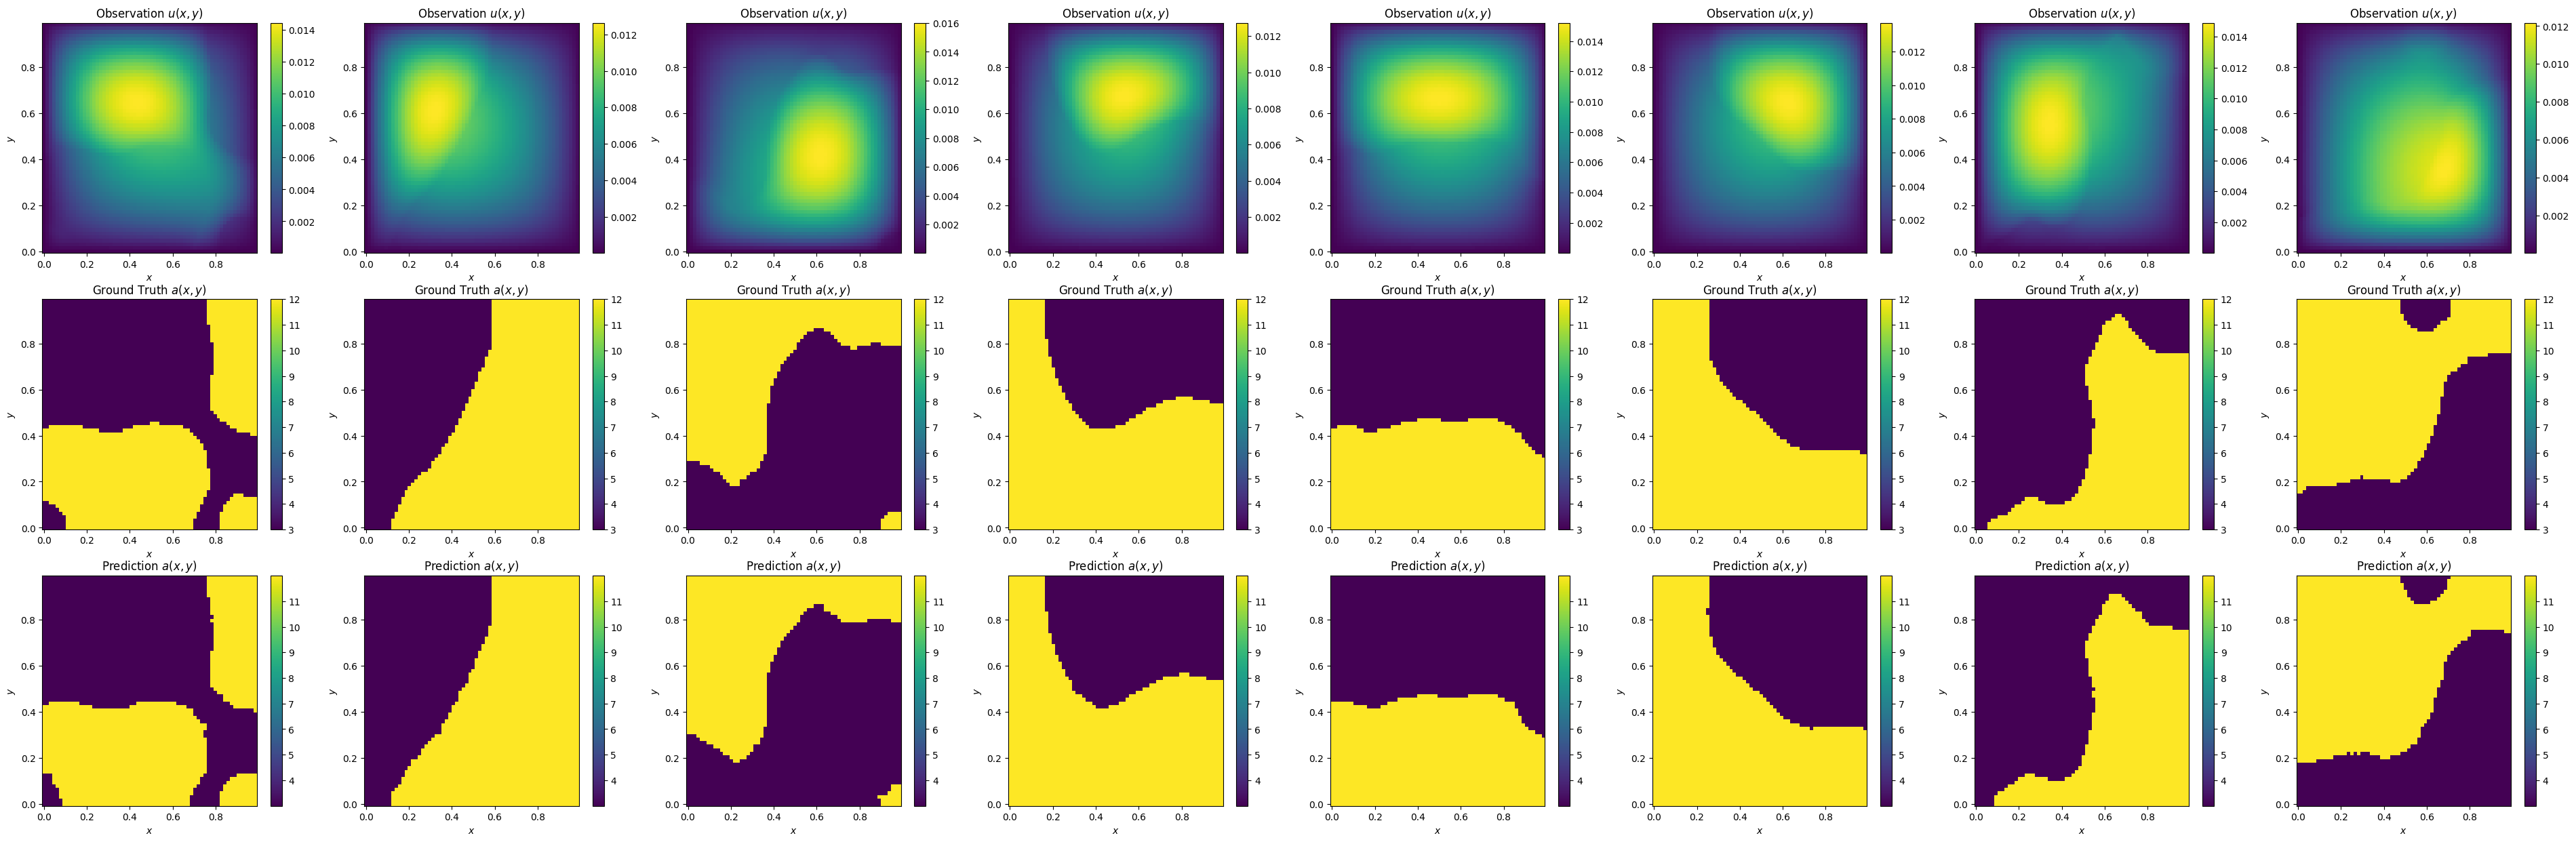

In [26]:
fig, ax = plt.subplots(3, 8, figsize=(48, 15))
for i in range(8):
    im1 = ax[0, i].pcolormesh(X, Y, y[i, 0])
    ax[0, i].set_xlabel('$x$')
    ax[0, i].set_ylabel('$y$')
    ax[0, i].set_title('Observation $u(x, y)$')
    fig.colorbar(im1, ax=ax[0, i])

    im2 = ax[1, i].pcolormesh(X, Y, x[i, 0])
    ax[1, i].set_xlabel('$x$')
    ax[1, i].set_ylabel('$y$')
    ax[1, i].set_title('Ground Truth $a(x, y)$')
    fig.colorbar(im2, ax=ax[1, i])

    im3 = ax[2, i].pcolormesh(X, Y, x_pred001_ec[i, 0])
    ax[2, i].set_xlabel('$x$')
    ax[2, i].set_ylabel('$y$')
    ax[2, i].set_title('Prediction $a(x, y)$')
    fig.colorbar(im3, ax=ax[2, i])

In [27]:
fig.savefig('../assets/darcy/darcy_prediction.png', dpi=300, bbox_inches='tight')

### Parameters comparison

In [15]:
def cal_mis_classification_rate(x, x_pred):
    b_size = x.shape[0]
    rate = torch.sum(torch.abs(x-x_pred) > 0.5, dim=(-1, -2)) / (64*64)
    mean = torch.mean(rate, axis=0).squeeze()
    std = torch.std(rate, axis=0).squeeze()
    return {'mean': mean, 'std': std}

In [16]:
mcr000 = cal_mis_classification_rate(x, x_pred000)
mcr001 = cal_mis_classification_rate(x, x_pred001)
mcr005 = cal_mis_classification_rate(x, x_pred005)
mcr010 = cal_mis_classification_rate(x, x_pred010)
mcr001_ec = cal_mis_classification_rate(x, x_pred001_ec)
mcr005_ec = cal_mis_classification_rate(x, x_pred005_ec)
mcr010_ec = cal_mis_classification_rate(x, x_pred010_ec)


In [17]:
print(f"Accuracy rate for 0.00 physics loss: {1-mcr000['mean']:.3%} ± {mcr000['std']:.3%}")
print(f"Accuracy rate for 0.01 physics loss: {1-mcr001['mean']:.3%} ± {mcr001['std']:.3%}")
print(f"Accuracy rate for 0.05 physics loss: {1-mcr005['mean']:.3%} ± {mcr005['std']:.3%}")
print(f"Accuracy rate for 0.10 physics loss: {1-mcr010['mean']:.3%} ± {mcr010['std']:.3%}")
print(f"Accuracy rate for 0.01 physics loss (error calibration): {1-mcr001_ec['mean']:.3%} ± {mcr001_ec['std']:.3%}")
print(f"Accuracy rate for 0.05 physics loss (error calibration): {1-mcr005_ec['mean']:.3%} ± {mcr005_ec['std']:.3%}")
print(f"Accuracy rate for 0.10 physics loss (error calibration): {1-mcr010_ec['mean']:.3%} ± {mcr010_ec['std']:.3%}")

Accuracy rate for 0.00 physics loss: 99.107% ± 0.622%
Accuracy rate for 0.01 physics loss: 98.860% ± 0.731%
Accuracy rate for 0.05 physics loss: 99.158% ± 0.554%
Accuracy rate for 0.10 physics loss: 99.132% ± 0.632%
Accuracy rate for 0.01 physics loss (error calibration): 99.187% ± 0.576%
Accuracy rate for 0.05 physics loss (error calibration): 99.169% ± 0.581%
Accuracy rate for 0.10 physics loss (error calibration): 99.165% ± 0.592%


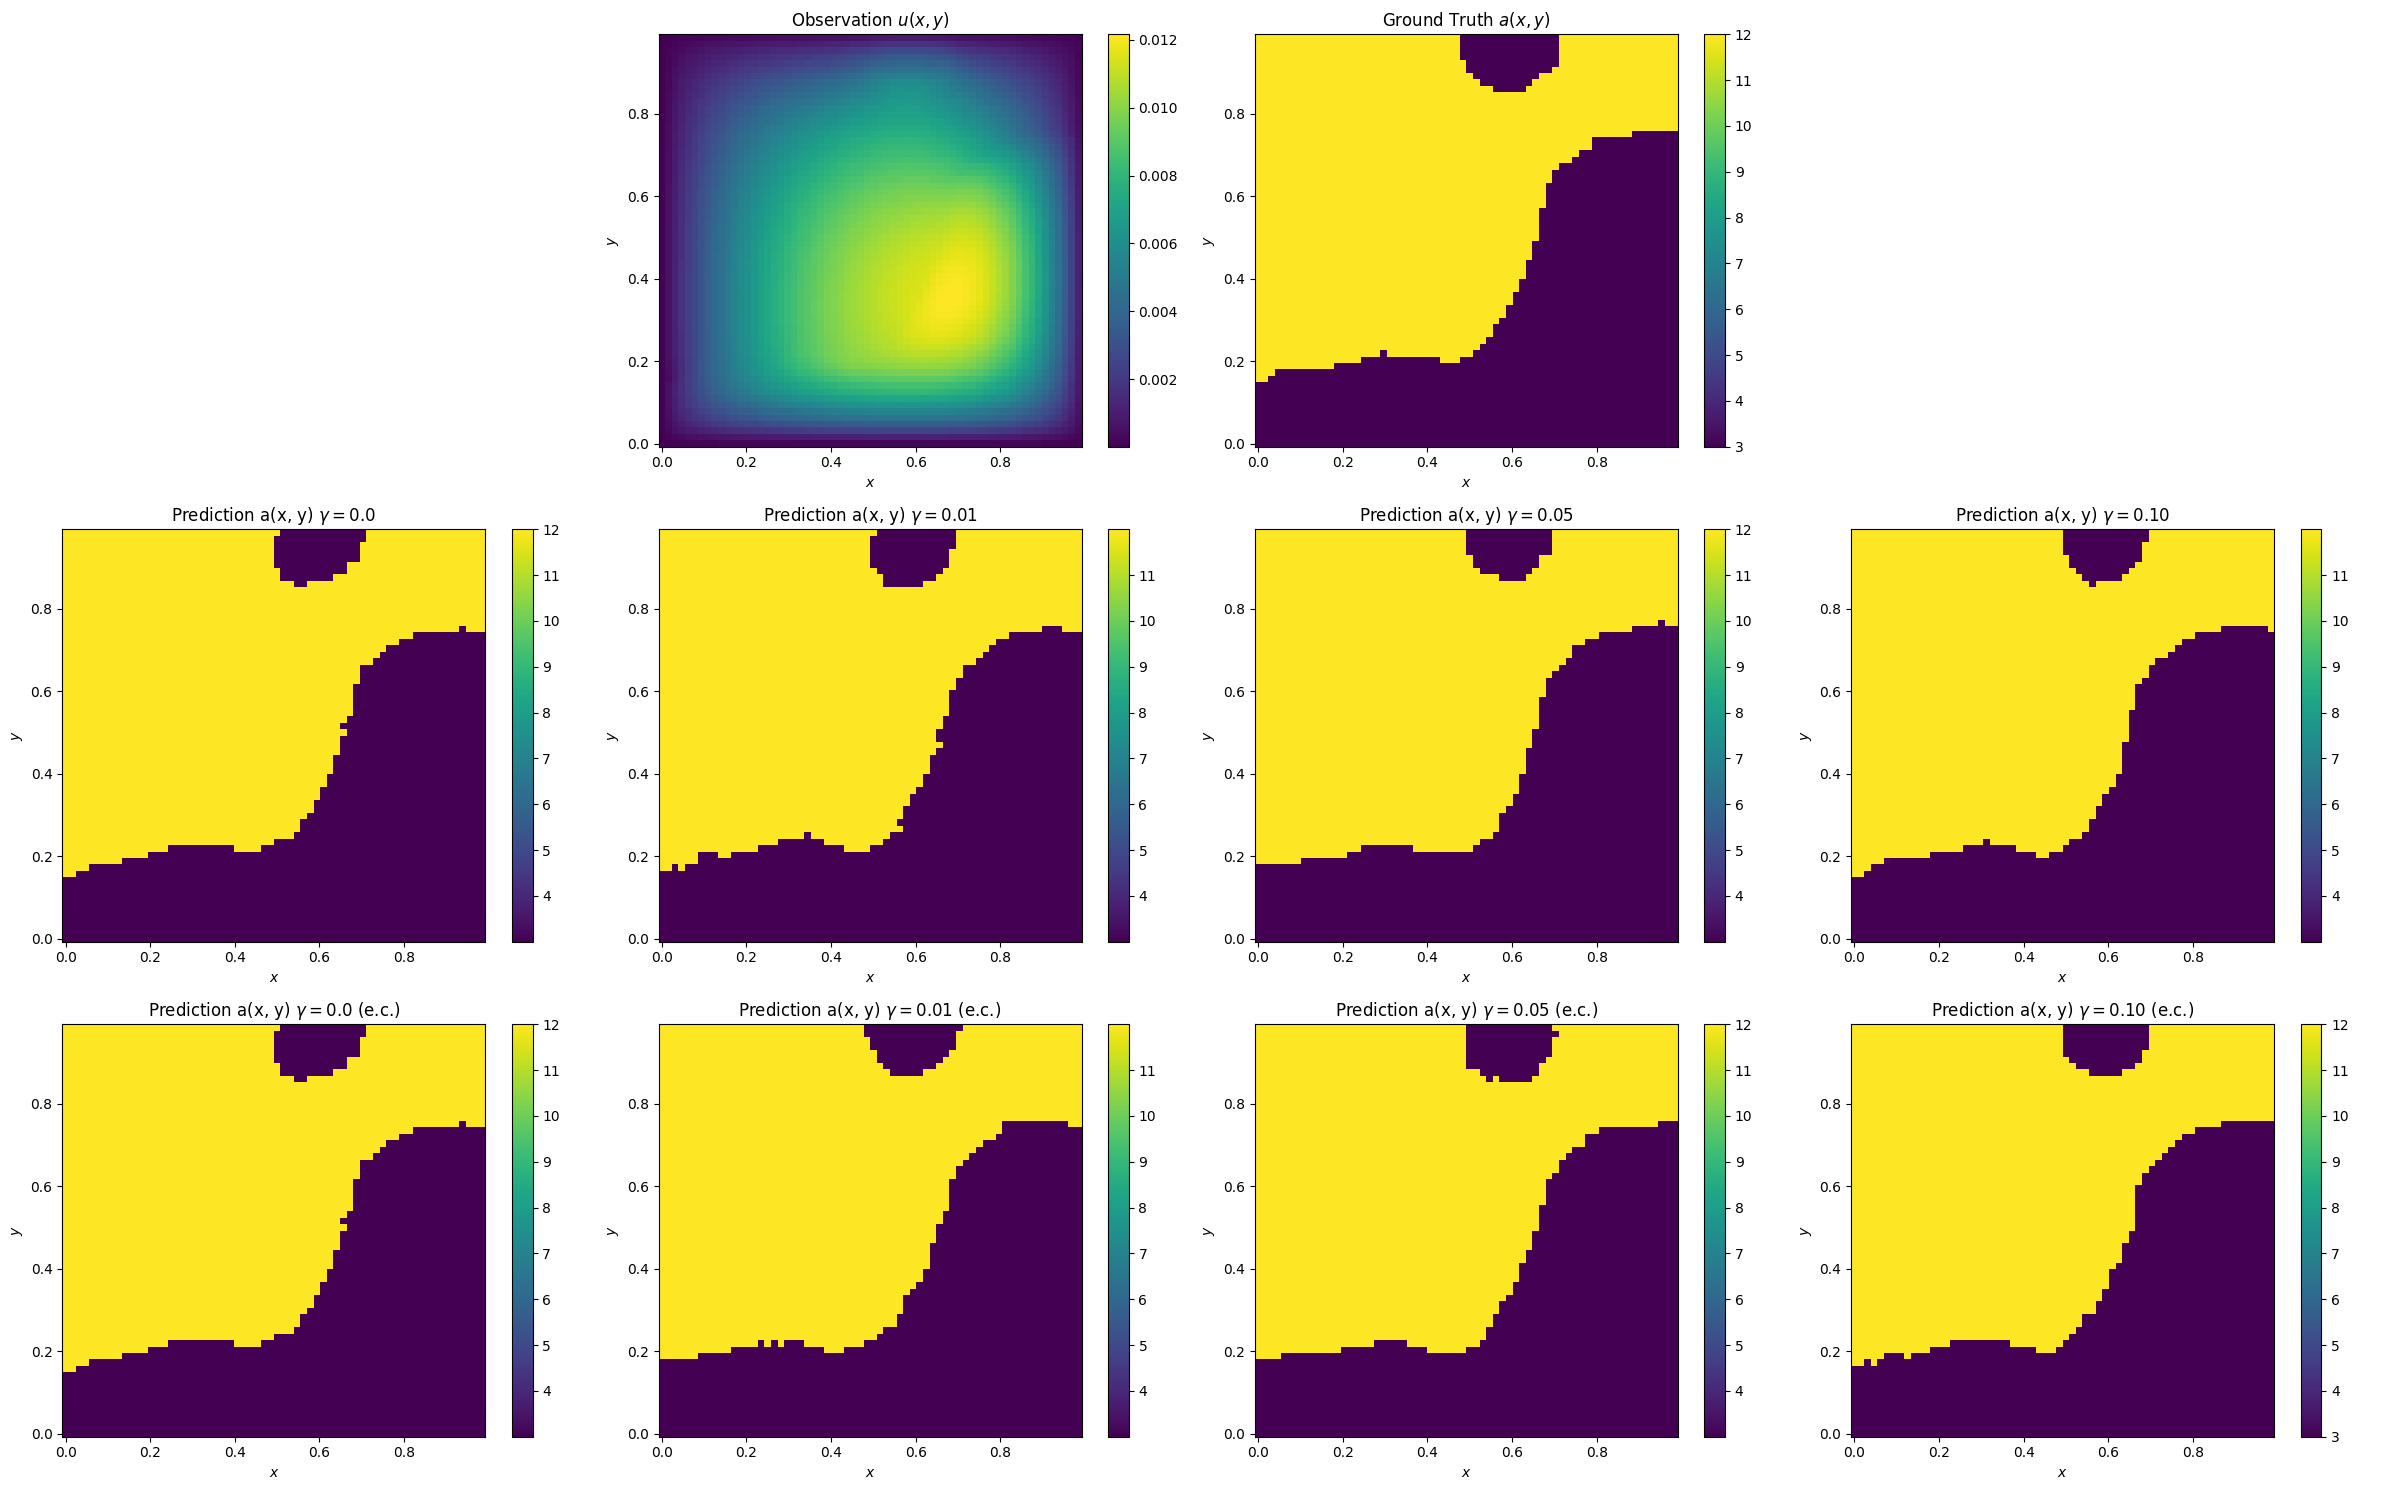

In [25]:
n = 7
fig, ax = plt.subplots(3, 4, figsize=(24, 15))
ax[0, 0].set_axis_off()
ax[0, 3].set_axis_off()

im1 = ax[0, 1].pcolormesh(X, Y, y[n, 0])
ax[0, 1].set_xlabel('$x$')
ax[0, 1].set_ylabel('$y$')
ax[0, 1].set_title('Observation $u(x, y)$')
fig.colorbar(im1, ax=ax[0, 1])
plt.tight_layout()

im2 = ax[0, 2].pcolormesh(X, Y, x[n, 0])
ax[0, 2].set_xlabel('$x$')
ax[0, 2].set_ylabel('$y$')
ax[0, 2].set_title('Ground Truth $a(x, y)$')
fig.colorbar(im2, ax=ax[0, 2])
plt.tight_layout()

im3 = ax[1, 0].pcolormesh(X, Y, x_pred000[n, 0])
ax[1, 0].set_xlabel('$x$')
ax[1, 0].set_ylabel('$y$')
ax[1, 0].set_title(r'Prediction a(x, y) $\gamma=0.0$')
fig.colorbar(im3, ax=ax[1, 0])
plt.tight_layout()

im4 = ax[1, 1].pcolormesh(X, Y, x_pred001[n, 0])
ax[1, 1].set_xlabel('$x$')
ax[1, 1].set_ylabel('$y$')
ax[1, 1].set_title(r'Prediction a(x, y) $\gamma=0.01$')
fig.colorbar(im4, ax=ax[1, 1])
plt.tight_layout()

im5 = ax[1, 2].pcolormesh(X, Y, x_pred005[n, 0])
ax[1, 2].set_xlabel('$x$')
ax[1, 2].set_ylabel('$y$')
ax[1, 2].set_title(r'Prediction a(x, y) $\gamma=0.05$')
fig.colorbar(im5, ax=ax[1, 2])
plt.tight_layout()

im6 = ax[1, 3].pcolormesh(X, Y, x_pred010[n, 0])
ax[1, 3].set_xlabel('$x$')
ax[1, 3].set_ylabel('$y$')
ax[1, 3].set_title(r'Prediction a(x, y) $\gamma=0.10$')
fig.colorbar(im6, ax=ax[1, 3])
plt.tight_layout()

im11 = ax[2, 0].pcolormesh(X, Y, x_pred000[n, 0])
ax[2, 0].set_xlabel('$x$')
ax[2, 0].set_ylabel('$y$')
ax[2, 0].set_title(r'Prediction a(x, y) $\gamma=0.0$ (e.c.)')
fig.colorbar(im11, ax=ax[2, 0])
plt.tight_layout()

im12 = ax[2, 1].pcolormesh(X, Y, x_pred001_ec[n, 0])
ax[2, 1].set_xlabel('$x$')
ax[2, 1].set_ylabel('$y$')
ax[2, 1].set_title(r'Prediction a(x, y) $\gamma=0.01$ (e.c.)')
fig.colorbar(im12, ax=ax[2, 1])
plt.tight_layout()

im13 = ax[2, 2].pcolormesh(X, Y, x_pred005_ec[n, 0])
ax[2, 2].set_xlabel('$x$')
ax[2, 2].set_ylabel('$y$')
ax[2, 2].set_title(r'Prediction a(x, y) $\gamma=0.05$ (e.c.)')
fig.colorbar(im13, ax=ax[2, 2])
plt.tight_layout()

im14 = ax[2, 3].pcolormesh(X, Y, x_pred010_ec[n, 0])
ax[2, 3].set_xlabel('$x$')
ax[2, 3].set_ylabel('$y$')
ax[2, 3].set_title(r'Prediction a(x, y) $\gamma=0.10$ (e.c.)')
fig.colorbar(im14, ax=ax[2, 3])
plt.tight_layout()


In [28]:
fig.savefig('../assets/darcy/darcy_parameters_comparison.png', dpi=300, bbox_inches='tight')

In [34]:
def cal_statistic_darcy_loss(u, a):
    u_list = torch.split(u, 1, dim=0)
    a_list = torch.split(a, 1, dim=0)
    losses = [Darcy_loss(u, a) for u, a in zip(u_list, a_list)]
    losses = torch.stack(losses)
    return {'mean': torch.mean(losses), 'std': torch.std(losses)}

In [35]:
phy = cal_statistic_darcy_loss(y, x)
phy_pred000 = cal_statistic_darcy_loss(y, x_pred000)
phy_pred001 = cal_statistic_darcy_loss(y, x_pred001)
phy_pred005 = cal_statistic_darcy_loss(y, x_pred005)
phy_pred010 = cal_statistic_darcy_loss(y, x_pred010)
phy_pred001_ec = cal_statistic_darcy_loss(y, x_pred001_ec)
phy_pred005_ec = cal_statistic_darcy_loss(y, x_pred005_ec)
phy_pred010_ec = cal_statistic_darcy_loss(y, x_pred010_ec)

In [36]:
print(f"Physics loss for ground truth: {phy['mean']:.4f} ± {phy['std']:.4f}")
print(f"Physics loss for 0.00 physics loss: {phy_pred000['mean']:.4f} ± {phy_pred000['std']:.4f}")
print(f"Physics loss for 0.01 physics loss: {phy_pred001['mean']:.4f} ± {phy_pred001['std']:.4f}")
print(f"Physics loss for 0.05 physics loss: {phy_pred005['mean']:.4f} ± {phy_pred005['std']:.4f}")
print(f"Physics loss for 0.10 physics loss: {phy_pred010['mean']:.4f} ± {phy_pred010['std']:.4f}")
print(f"Physics loss for 0.01 physics loss (error calibration): {phy_pred001_ec['mean']:.4f} ± {phy_pred001_ec['std']:.4f}")
print(f"Physics loss for 0.05 physics loss (error calibration): {phy_pred005_ec['mean']:.4f} ± {phy_pred005_ec['std']:.4f}")
print(f"Physics loss for 0.10 physics loss (error calibration): {phy_pred010_ec['mean']:.4f} ± {phy_pred010_ec['std']:.4f}")

Physics loss for ground truth: 1.1002 ± 0.0972
Physics loss for 0.00 physics loss: 1.2578 ± 0.1720
Physics loss for 0.01 physics loss: 1.3412 ± 0.2187
Physics loss for 0.05 physics loss: 1.2047 ± 0.1613
Physics loss for 0.10 physics loss: 1.1854 ± 0.1623
Physics loss for 0.01 physics loss (error calibration): 1.1716 ± 0.1679
Physics loss for 0.05 physics loss (error calibration): 1.1848 ± 0.1633
Physics loss for 0.10 physics loss (error calibration): 1.1507 ± 0.1676


### Noise Test

In [50]:
x = ds[74:75]['x']
y = ds[74:75]['y']

In [51]:
def noise_data(y, percent):
    noise_index = torch.randperm(64*64)[:int(64*64*percent)]
    y_noise = y.clone()
    y_noise[0, 0, noise_index//64, noise_index%64] = torch.rand(len(noise_index)) * y.std() + y.mean()
    return y_noise

In [52]:
y_noise001 = noise_data(y, 0.01)
y_noise005 = noise_data(y, 0.05)
y_noise010 = noise_data(y, 0.10)

In [53]:
y_new = torch.cat([y, y_noise001, y_noise005, y_noise010], dim=0)

In [54]:
x_pred = make_prediction(diffusion_model, y_new, 0.00)

DDPM sampling: 100%|██████████| 600/600 [00:21<00:00, 28.46it/s]


In [55]:
x = x.numpy().squeeze()
y = y.numpy().squeeze()

In [56]:
x_pred = x_pred.numpy().squeeze()

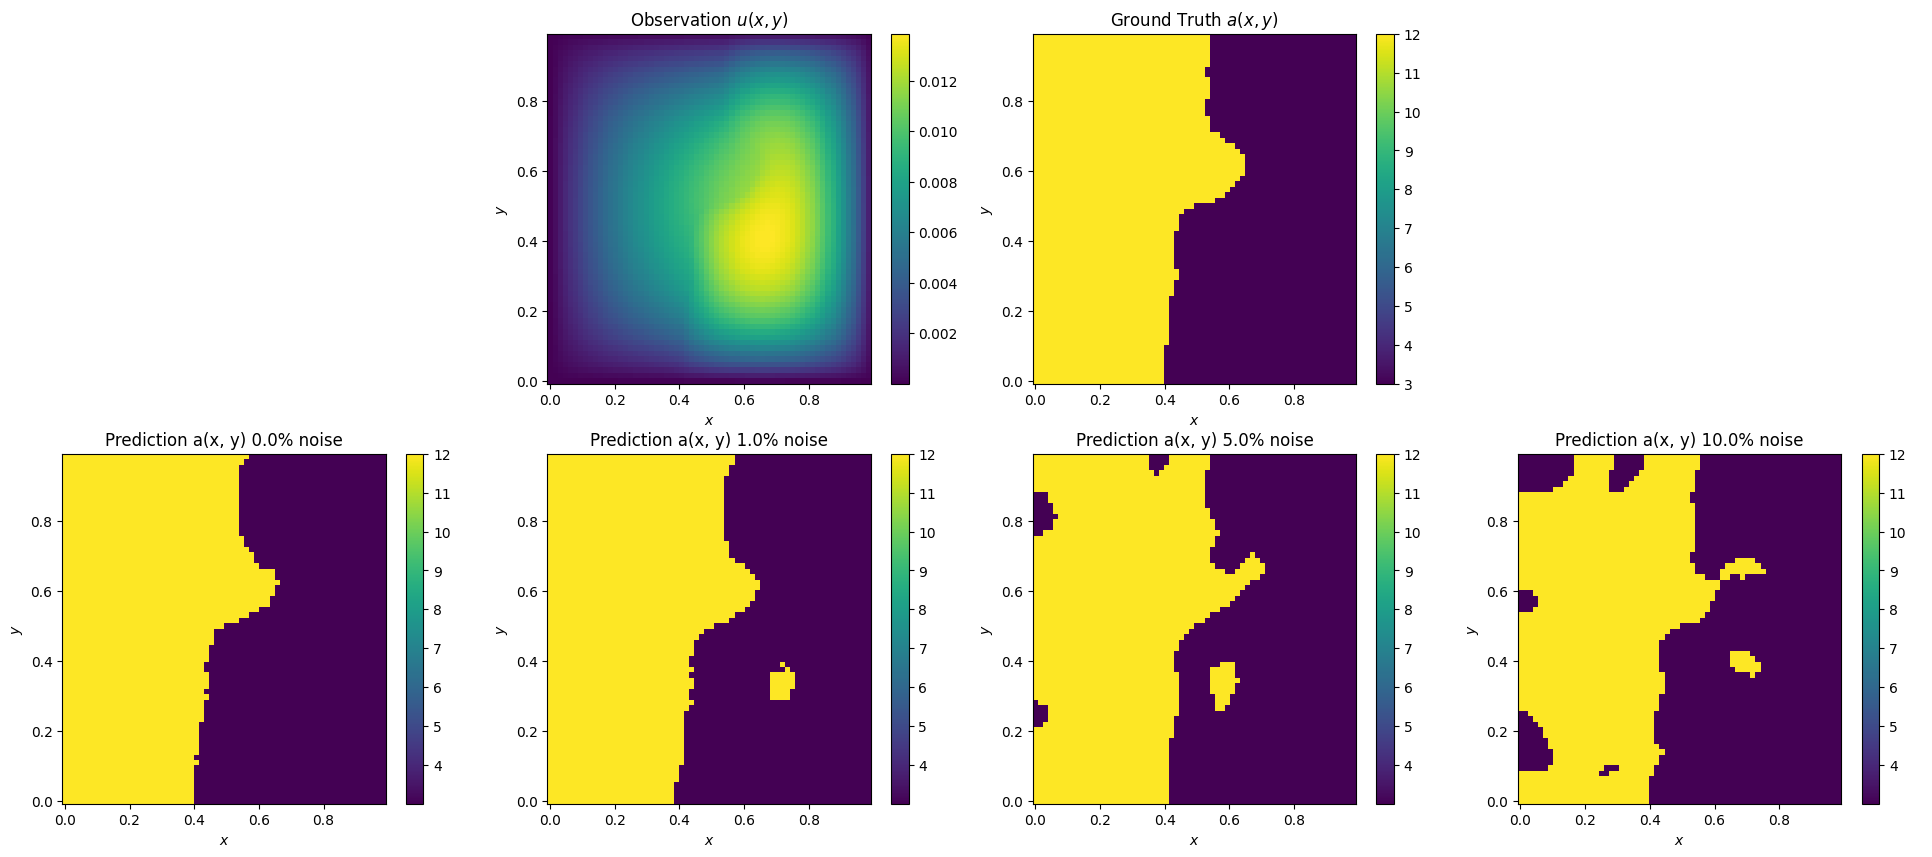

In [57]:
fig, ax = plt.subplots(2, 4, figsize=(24, 10))
ax[0, 0].set_axis_off()
ax[0, 3].set_axis_off()

im1 = ax[0, 1].pcolormesh(X, Y, y)
ax[0, 1].set_xlabel('$x$')
ax[0, 1].set_ylabel('$y$')
ax[0, 1].set_title('Observation $u(x, y)$')
fig.colorbar(im1, ax=ax[0, 1])

im2 = ax[0, 2].pcolormesh(X, Y, x)
ax[0, 2].set_xlabel('$x$')
ax[0, 2].set_ylabel('$y$')
ax[0, 2].set_title('Ground Truth $a(x, y)$')
fig.colorbar(im2, ax=ax[0, 2])

im3 = ax[1, 0].pcolormesh(X, Y, x_pred[0])
ax[1, 0].set_xlabel('$x$')
ax[1, 0].set_ylabel('$y$')
ax[1, 0].set_title(r'Prediction a(x, y) 0.0% noise')
fig.colorbar(im3, ax=ax[1, 0])

im4 = ax[1, 1].pcolormesh(X, Y, x_pred[1])
ax[1, 1].set_xlabel('$x$')
ax[1, 1].set_ylabel('$y$')
ax[1, 1].set_title(r'Prediction a(x, y) 1.0% noise')
fig.colorbar(im4, ax=ax[1, 1])

im5 = ax[1, 2].pcolormesh(X, Y, x_pred[2])
ax[1, 2].set_xlabel('$x$')
ax[1, 2].set_ylabel('$y$')
ax[1, 2].set_title(r'Prediction a(x, y) 5.0% noise')
fig.colorbar(im5, ax=ax[1, 2])

im6 = ax[1, 3].pcolormesh(X, Y, x_pred[3])
ax[1, 3].set_xlabel('$x$')
ax[1, 3].set_ylabel('$y$')
ax[1, 3].set_title(r'Prediction a(x, y) 10.0% noise')
fig.colorbar(im6, ax=ax[1, 3])

In [58]:
fig.savefig('../assets/darcy/darcy_noise.png', dpi=300, bbox_inches='tight')